# Project 1 Development Notebook: Climate and Housing

This file contains development code for project 1 for ECON 1680. It contains all code required to replicate the results outlined in the draft. Inline citations are included for all code segments that are not original. The code first cleans the data, generates some descriptive statistics, and then leverages the methodology discussed in the paper: 
We use different regressions and dimension reduction techniques to analyze the relationship between climate risk and housing prices, using space as our source of variation.

## 1. Imports and Functions

In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
def is_date(string):
    # From https://stackoverflow.com/questions/25341945/check-if-string-has-date-any-format
    #   Checks if a string can be interpreted as a date
    try:
        parse(string)
        return True
    except ValueError:
        return False

In [3]:
def get_pct_change(row, date_vars):
    # This function gets the percentage change in ZHVI from 2000-2015 for a given county.
    #   We use this later to generate one of our dependent variables.

    start_mean = row[date_vars[:12]].mean()
    end_mean = row[date_vars[180:192]].mean()
    return (end_mean - start_mean) / start_mean

In [4]:
def get_volatility(row, date_vars):
    # This function average of the yearly coefficients of variation in ZHVI in a county.
    coef_of_vars = []
    for n in range(0, len(date_vars), 12):
        year_vars = date_vars[n:n + 12]
        year_price_data = row[year_vars].tolist()

        # Drop year observations if we don't have sufficient data to calculate the coefficient of variation.
        if True not in [np.isnan(i) for i in year_price_data]:
            coef_of_vars.append(np.std(year_price_data) / np.mean(year_price_data))
        
    # If we have no information about volatility, return missing.
    if coef_of_vars == []:
        return np.nan
    return np.mean(coef_of_vars)

## 2. Data: Cleaning and Saving

In [5]:
# Path to production directory: note that you must include Data, Figures, and Code subdirectories.
path = "C:\\Users\\garvg\\Downloads\\Project 1\\ClimateAndHousing\\"

# Read in CSV data
zillow = pd.read_csv(path + "Data\\zillow.csv")
nri_fema = pd.read_csv(path + "Data\\nri_fema.csv")
oi_covars = pd.read_csv(path + "Data\\oi_covars.csv")

In [6]:
# Merge CSV data by State and County FIPS codes and save
clim_hous_data = zillow.merge(nri_fema, on=["state_fips", "county_fips"], validate="one_to_one")
all_data = clim_hous_data.merge(oi_covars, on=["state_fips", "county_fips"], validate="one_to_one")
all_data.to_csv(path + "Data\\all_data.csv", index=False)

In [7]:
# Specify columns to keep: hazard scores, controls, and house value

# The technical report for variables from the NRI project can be found linked in the next cell.
hazard_vars = [
    "Avalanche", "Coastal Flooding", "Cold Wave", "Drought", "Earthquake", 
    "Hail", "Heat Wave", "Hurricane", "Ice Storm", "Landslide", "Lightning",
    "Riverine Flooding", "Strong Wind", "Tornado", "Tsunami", "Volcanic Activity",
    "Wildfire", "Winter Weather"]
hazard_vars = [hazard + " - Hazard Type Risk Index Score" for hazard in hazard_vars]
hazard_vars.append("National Risk Index - Score - Composite")

# Information on the Zillow data can be found here: https://www.zillow.com/research/data/
housing_vars = [col for col in all_data.columns if is_date(col) and "202" not in col]
housing_vars.sort()

# Information on the variables from the Opportunity Atlas project can be found here:
#   https://opportunityinsights.org/wp-content/uploads/2019/07/Codebook-for-Table-10.pdf
control_vars = [
    "Population (2020)", "Building Value ($)", "Agriculture Value ($)", "Area (sq mi)", "job_density_2013",
    "ann_avg_job_growth_2004_2013", "ln_wage_growth_hs_grad", "emp2000", "foreign_share2010", 
    "mean_commutetime2000", "frac_coll_plus2000", "frac_coll_plus2010", 
    "hhinc_mean2000",  "med_hhinc2016", "poor_share2000", "poor_share2010",
    "share_white2000", "share_black2000", "share_hisp2000", "share_asian2000",
    "share_white2010", "share_black2010", "share_hisp2010", "share_asian2010"
    ]

columns = ["State Name", "County Name", "state_fips", "county_fips"]
columns.extend(hazard_vars)
columns.extend(housing_vars)
columns.extend(control_vars)

all_data_pruned = all_data[columns]

In [8]:
# For hazard data, rename variables and replace missing values with zeroes:
#   Missing values imply that "Community is not considered at risk for hazard type."
#   according to the official NRI documentation here:
#   https://www.fema.gov/sites/default/files/documents/fema_national-risk-index_technical-documentation.pdf
hazard_rename_dict = dict()

for hazard in hazard_vars:
    hazard_rename_dict[hazard] = hazard[:hazard.index(" - ")]
    all_data_pruned[hazard] = all_data_pruned[hazard].fillna(0)

all_data_pruned = all_data_pruned.rename(hazard_rename_dict, axis=1)

C:\Users\garvg\AppData\Local\Temp\ipykernel_25712\2145004020.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_pruned[hazard] = all_data_pruned[hazard].fillna(0)


### Dependent Variable Generation

The NRI takes into account historical loss data from 1996-2019 when computing natural hazard risk. We can thus take the NRI as a measure of both hazard risk and historical hazard loss. This can be supported by the documentation, which is included here: https://www.fema.gov/sites/default/files/documents/fema_national-risk-index_technical-documentation.pdf. This will be corroborated later, as we will show that the incidence of certain natural disasters in South Carolina is strongly correlated with these risk indices.

We bring this up to explain that we will consider Zillow home value data (the Zillow Home Value Index, or ZHVI is our measure) from the years 2000 (earliest available) to 2019. Our dependent variables will thus be the following:
1. Mean house value over this period (to capture the relationship between risk and magnitude of housing prices)
2. Average percentage change in housing price (to capture the relationship between risk and long-term upward/downward trends)
3. Average within-year variance in housing price (to capture the relationship between risk and short-term housing price volatility)

We generate these values below.

In [9]:
# Generate mean ZHVI over 2000-2019
all_data_pruned["ZHVI_mean"] = all_data_pruned[housing_vars].mean(axis=1)

# Generate mean percentage change over 2000-2019
all_data_pruned["ZHVI_trend"] = all_data_pruned.apply(get_pct_change, args=(housing_vars,), axis=1)

# Generate mean within-year (month-to-month) variance over 2000-2019
all_data_pruned["ZHVI_vol"] = all_data_pruned.apply(get_volatility, args=(housing_vars,), axis=1) 

In [10]:
# Drop unnecessary variables
all_data_pruned = all_data_pruned.drop(columns=housing_vars)

# Save data after cleaning
all_data_pruned.to_csv(path + "Data\\all_data_pruned.csv", index=False)

## 3. Descriptive Statistics

Note: After running the above code, we may always start here since the pre-processing steps are saved in the all_data_pruned.csv file.

In [11]:
# Load data
working_data = pd.read_csv(path + "Data\\all_data_pruned.csv")
working_data.head()

,State Name,County Name,state_fips,county_fips,Avalanche,Coastal Flooding,Cold Wave,Drought,Earthquake,Hail,...,share_black2000,share_hisp2000,share_asian2000,share_white2010,share_black2010,share_hisp2010,share_asian2010,ZHVI_mean,ZHVI_trend,ZHVI_vol
0,California,Los Angeles,6,37,33.653846,43.259557,0.000000,73.846643,100.000000,48.106904,...,0.100307,0.439193,0.105664,0.277873,0.089271,0.477450,0.121261,421124.410815,1.186984,0.034877
1,Illinois,Cook,17,31,0.000000,44.265594,100.000000,19.949093,96.659243,93.923003,...,0.242277,0.196171,0.046331,0.438595,0.249698,0.239623,0.056553,197042.801648,0.296597,0.020780
2,Texas,Harris,48,201,0.000000,73.843058,99.204582,88.450525,90.741330,94.050270,...,0.176150,0.307376,0.045832,0.329789,0.189457,0.408444,0.051969,140117.773455,0.488805,0.013150
3,Arizona,Maricopa,4,13,0.000000,0.000000,0.000000,85.841553,98.218263,99.331849,...,0.037874,0.243300,0.017987,0.586845,0.054242,0.295705,0.030152,206654.847968,0.492423,0.034382
4,California,San Diego,6,73,31.250000,32.796781,0.000000,89.564111,99.745466,22.589882,...,0.060665,0.260778,0.083679,0.484619,0.055997,0.320274,0.098978,424881.784092,1.074410,0.030891


In [12]:
# Write descriptive statistics to logfile
summary_statistics = working_data.describe()
summary_statistics.to_csv(path + '\\Figures\\Descriptive\\summary_statistics.csv', index_label='Metric')
summary_statistics.head()

,state_fips,county_fips,Avalanche,Coastal Flooding,Cold Wave,Drought,Earthquake,Hail,Heat Wave,Hurricane,...,share_black2000,share_hisp2000,share_asian2000,share_white2010,share_black2010,share_hisp2010,share_asian2010,ZHVI_mean,ZHVI_trend,ZHVI_vol
count,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,...,3073.000000,3073.000000,3050.000000,3073.000000,3073.000000,3073.000000,3059.000000,3005.000000,1054.000000,2988.000000
mean,30.279857,103.366417,3.230056,7.867445,46.351206,49.280821,50.595847,50.327553,49.254025,36.173363,...,0.088648,0.060585,0.007259,0.786937,0.094079,0.082362,0.009541,138742.559884,0.477520,0.016478
std,15.063746,107.779895,14.412471,21.809221,33.456454,30.498124,28.676059,28.770805,30.869760,33.256354,...,0.142850,0.116709,0.019129,0.192676,0.145760,0.129940,0.021505,80068.204022,0.296292,0.006075
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000820,0.000000,0.028604,0.000000,0.001311,0.000000,24942.839331,-0.314240,0.002858
25%,19.000000,35.000000,0.000000,0.000000,0.000000,25.167038,25.930640,25.389755,26.057906,0.000000,...,0.004115,0.009270,0.001705,0.673463,0.007189,0.016089,0.002425,91076.527040,0.281172,0.012313


## 4. Regressions

We use standard OLS estimation, LASSO, and Ridge regressions to capture both what variables are the most correlated and predictive of long-term trends, average magnitude, and short-term volatility in local housing prices.

In [13]:
# Create lists of independent (hr) and dependent (y) variables for analysis
hr_vars = [hazard_rename_dict[i] for i in hazard_vars]
hr_vars.remove("National Risk Index")
y_vars = ["ZHVI_mean", "ZHVI_trend", "ZHVI_vol"]

### OLS

We use this approach as a baseline estimator of the relationships between hazard risk and housing price characteristics.

In [14]:
# Conduct OLS Regression on mean ZHVI (without controls)
considered = hr_vars + ["ZHVI_mean"]
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_mean"]
working_xs = sm.add_constant(mod_working_data[hr_vars])

mean_ols_no_X = sm.OLS(working_ys, working_xs).fit()
print(mean_ols_no_X.summary())

# Coefficients of interest
coefs = [i for i in mean_ols_no_X.params.keys()]
coefs.pop(0)

                            OLS Regression Results                            
Dep. Variable:              ZHVI_mean   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     85.19
Date:                Sun, 12 May 2024   Prob (F-statistic):          2.06e-252
Time:                        13:01:16   Log-Likelihood:                -37569.
No. Observations:                3005   AIC:                         7.518e+04
Df Residuals:                    2986   BIC:                         7.529e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9.191e+04   5216.09

'const'

                            OLS Regression Results                            
Dep. Variable:              ZHVI_mean   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     183.1
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        13:01:16   Log-Likelihood:                -28150.
No. Observations:                2341   AIC:                         5.639e+04
Df Residuals:                    2298   BIC:                         5.663e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

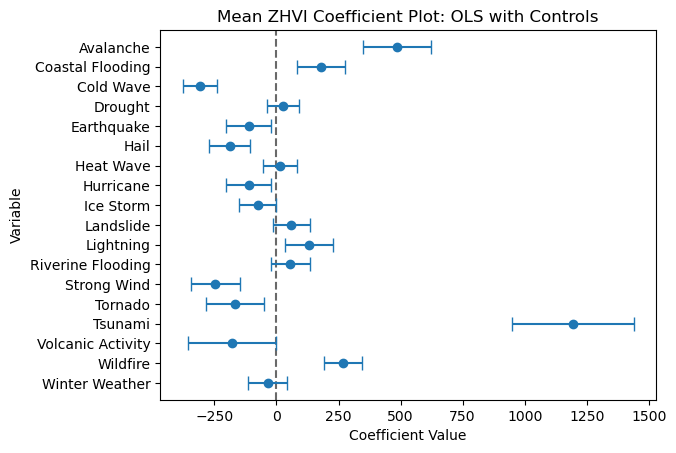

In [15]:
# Conduct OLS Regression on mean ZHVI (with controls)
considered = hr_vars + ["ZHVI_mean"] + control_vars
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_mean"]
working_xs = sm.add_constant(mod_working_data[hr_vars + control_vars])

mean_ols_X = sm.OLS(working_ys, working_xs).fit()
print(mean_ols_X.summary())

#for table in mean_ols_X.summary().tables:
#    print(table.as_csv())

# Create coefficient plot

coefs = coefs[::-1]
coef_points = [mean_ols_X.params[i] for i in coefs]
errors = [mean_ols_X.bse[i] * 2 for i in coefs]

plt.figure()
plt.axvline(x=0, linestyle='--', color='dimgray')
plt.errorbar(coef_points, coefs, xerr=errors, fmt='o', capsize=5)
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Mean ZHVI Coefficient Plot: OLS with Controls')
plt.savefig(path + "\\Figures\\MeanZHVIPlot.png", dpi=500,  bbox_inches='tight')
plt.show()

In [16]:
# Conduct OLS Regression on change in ZHVI (without controls)
considered = hr_vars + ["ZHVI_trend"]
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_trend"]
working_xs = sm.add_constant(mod_working_data[hr_vars])

trend_ols_no_X = sm.OLS(working_ys, working_xs).fit()
print(trend_ols_no_X.summary())

                            OLS Regression Results                            
Dep. Variable:             ZHVI_trend   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     24.23
Date:                Sun, 12 May 2024   Prob (F-statistic):           8.07e-67
Time:                        13:01:18   Log-Likelihood:                -27.674
No. Observations:                1054   AIC:                             93.35
Df Residuals:                    1035   BIC:                             187.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4583      0.03

                            OLS Regression Results                            
Dep. Variable:             ZHVI_trend   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     31.43
Date:                Sun, 12 May 2024   Prob (F-statistic):          8.96e-143
Time:                        13:01:18   Log-Likelihood:                 218.94
No. Observations:                 880   AIC:                            -351.9
Df Residuals:                     837   BIC:                            -146.3
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

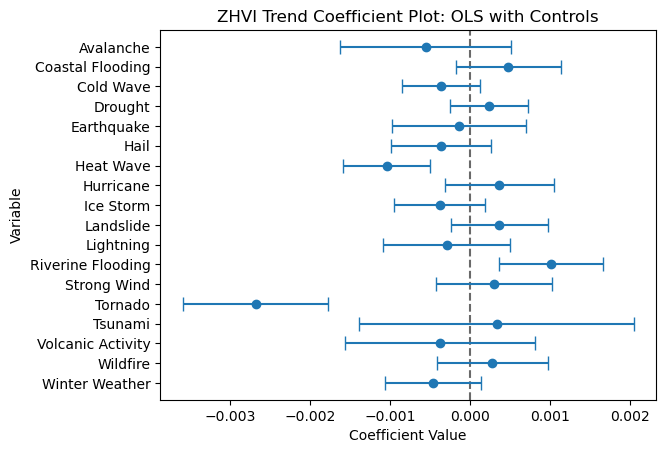

In [17]:
# Conduct OLS Regression on change in ZHVI (with controls)
considered = hr_vars + ["ZHVI_trend"] + control_vars
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_trend"]
working_xs = sm.add_constant(mod_working_data[hr_vars + control_vars])

trend_ols_X = sm.OLS(working_ys, working_xs).fit()
print(trend_ols_X.summary())

#for table in trend_ols_X.summary().tables:
#    print(table.as_csv())

coef_points = [trend_ols_X.params[i] for i in coefs]
errors = [trend_ols_X.bse[i] * 2 for i in coefs]

plt.figure()
plt.axvline(x=0, linestyle='--', color='dimgray')
plt.errorbar(coef_points, coefs, xerr=errors, fmt='o', capsize=5)
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('ZHVI Trend Coefficient Plot: OLS with Controls')
plt.savefig(path + "\\Figures\\TrendZHVIPlot.png", dpi=500,  bbox_inches='tight')
plt.show()

In [18]:
# Conduct OLS Regression on yearly volatility in ZHVI (without controls)
considered = hr_vars + ["ZHVI_vol"]
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_vol"]
working_xs = sm.add_constant(mod_working_data[hr_vars])

vol_ols_no_X = sm.OLS(working_ys, working_xs).fit()
print(vol_ols_no_X.summary())

                            OLS Regression Results                            
Dep. Variable:               ZHVI_vol   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     39.70
Date:                Sun, 12 May 2024   Prob (F-statistic):          1.11e-124
Time:                        13:01:20   Log-Likelihood:                 11332.
No. Observations:                2988   AIC:                        -2.263e+04
Df Residuals:                    2969   BIC:                        -2.251e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0166      0.00

                            OLS Regression Results                            
Dep. Variable:               ZHVI_vol   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     27.45
Date:                Sun, 12 May 2024   Prob (F-statistic):          4.66e-170
Time:                        13:01:20   Log-Likelihood:                 9027.0
No. Observations:                2330   AIC:                        -1.797e+04
Df Residuals:                    2287   BIC:                        -1.772e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

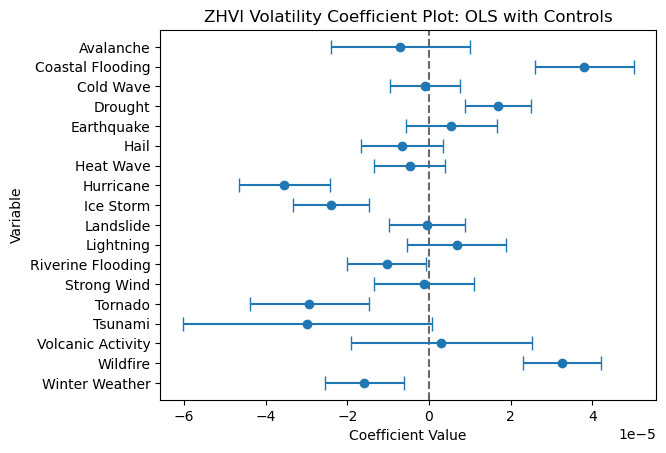

In [19]:
# Conduct OLS Regression on yearly volatility in ZHVI (with controls)
considered = hr_vars + ["ZHVI_vol"] + control_vars
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_vol"]
working_xs = sm.add_constant(mod_working_data[hr_vars + control_vars])

vol_ols_X = sm.OLS(working_ys, working_xs).fit()
print(vol_ols_X.summary())

#for table in vol_ols_X.summary().tables:
#    print(table.as_latex_tabular())

coef_points = [vol_ols_X.params[i] for i in coefs]
errors = [vol_ols_X.bse[i] * 2 for i in coefs]

plt.figure()
plt.axvline(x=0, linestyle='--', color='dimgray')
plt.errorbar(coef_points, coefs, xerr=errors, fmt='o', capsize=5)
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('ZHVI Volatility Coefficient Plot: OLS with Controls')
plt.savefig(path + "\\Figures\\VolZHVIPlot.png", dpi=500,  bbox_inches='tight')
plt.show()

### LASSO

We conduct this analysis to assess variable selection and dimension reduction, particularly in the context of what hazards are important in predicting ZHVI characteristics.

MSE: 4174784778.682541
1e-06


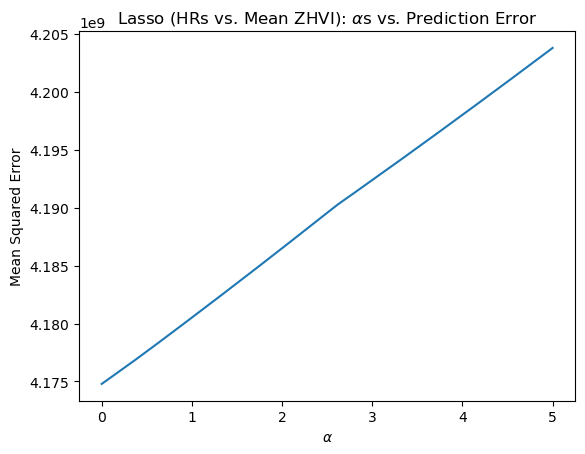

In [20]:
# Conduct LASSO Regression on mean ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Note: Code inspired by and borrowed from review session + homework 2
# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_mean_no_X = None
opt_alpha_lasso_mean_no_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 5, num=500)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)

    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_mean_no_X = alphas[counter]
        opt_coefs_lasso_mean_no_X = model['lasso'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_lasso_mean_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs vs. Mean ZHVI): $\alpha$s vs. Prediction Error') # Note here that HR stands for hazard risk
plt.savefig(path + '\\Figures\\LASSO\\alphaMeanZHVILASSO.png')
plt.show()

MSE: 1829220989.2147403


c:\Users\garvg\anaconda3\envs\mlta\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e+12, tolerance: 1.499e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\garvg\anaconda3\envs\mlta\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.964e+09, tolerance: 1.499e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\garvg\anaconda3\envs\mlta\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

MSE: 1824451898.7619317
0.4809628276553106


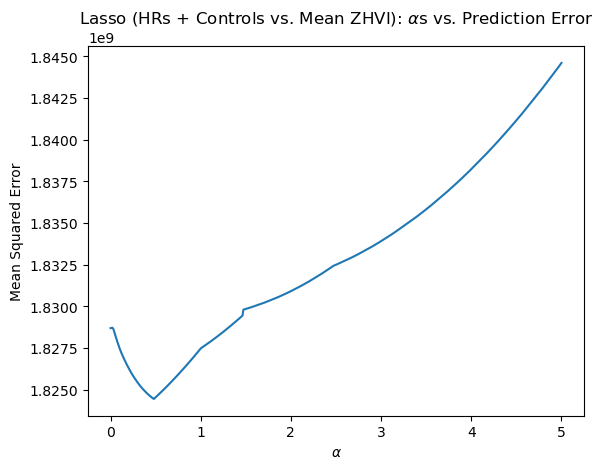

In [21]:
# Conduct LASSO Regression on mean ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Conduct standardized OLS regression

std_ols_mean_X = make_pipeline(StandardScaler(with_mean=False), 
                             LinearRegression())
std_ols_mean_X.fit(X_train, y_train)

y_pred = std_ols_mean_X.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_mean_X = None
opt_alpha_lasso_mean_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_mean_X = alphas[counter]
        opt_coefs_lasso_mean_X = model['lasso'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_lasso_mean_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs + Controls vs. Mean ZHVI): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaXMeanZHVILASSO.png')
plt.show()

MSE: 0.06730514626738342
1e-06


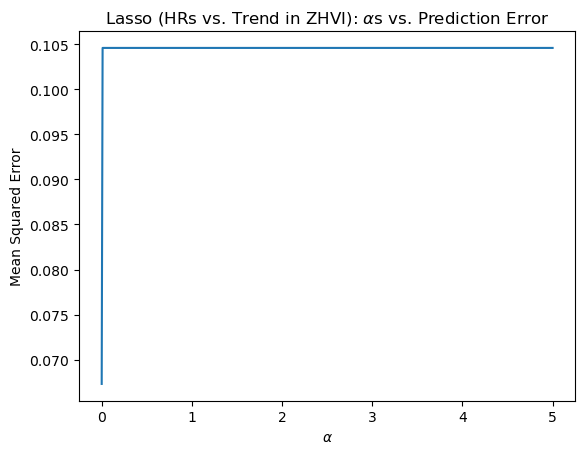

In [22]:
# Conduct LASSO Regression on change in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Note: Code also inspired by and borrowed from review session
# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_trend_no_X = None
opt_alpha_lasso_trend_no_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_trend_no_X = alphas[counter]
        opt_coefs_lasso_trend_no_X = model['lasso'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_lasso_trend_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs vs. Trend in ZHVI): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaTrendZHVILASSO.png')
plt.show()

MSE: 0.03550567167418513


c:\Users\garvg\anaconda3\envs\mlta\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.038e+00, tolerance: 7.229e-03
  model = cd_fast.enet_coordinate_descent(


MSE: 0.0352386604814535
1e-06


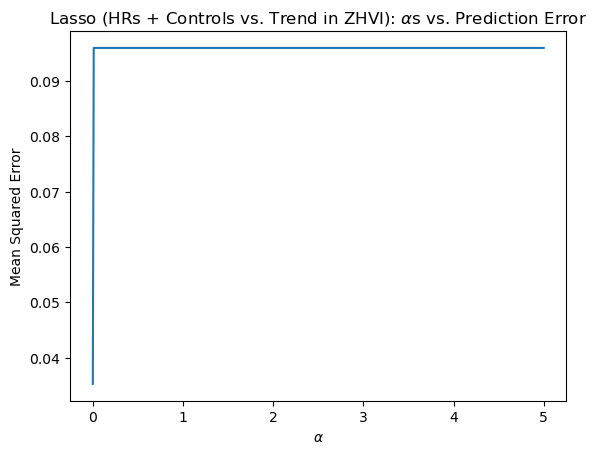

In [23]:
# Conduct LASSO Regression on change in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Conduct standardized OLS regression

std_ols_trend_X = make_pipeline(StandardScaler(with_mean=False), 
                             LinearRegression())
std_ols_trend_X.fit(X_train, y_train)

y_pred = std_ols_trend_X.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_trend_X = None
opt_alpha_lasso_trend_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_trend_X = alphas[counter]
        opt_coefs_lasso_trend_X = model['lasso'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_lasso_trend_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs + Controls vs. Trend in ZHVI): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaXTrendZHVILASSO.png')
plt.show()

MSE: 3.310437787501218e-05
1e-06


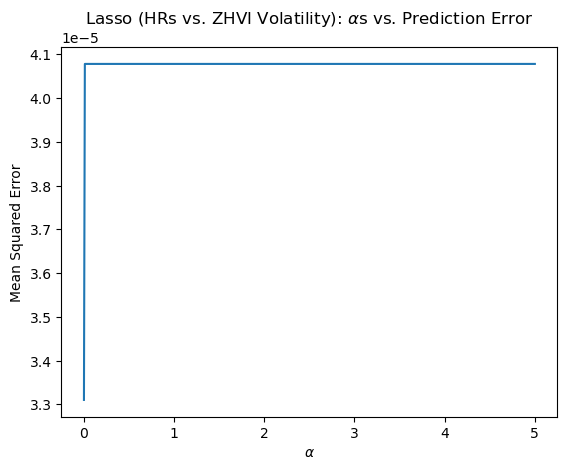

In [24]:
# Conduct LASSO Regression on yearly volatility in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_vol_no_X = None
opt_alpha_lasso_vol_no_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_vol_no_X = alphas[counter]
        opt_coefs_lasso_vol_no_X = model['lasso'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_lasso_vol_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs vs. ZHVI Volatility): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaVolZHVILASSO.png')
plt.show()

MSE: 3.061453781438619e-05
MSE: 3.023987540704233e-05
1e-06


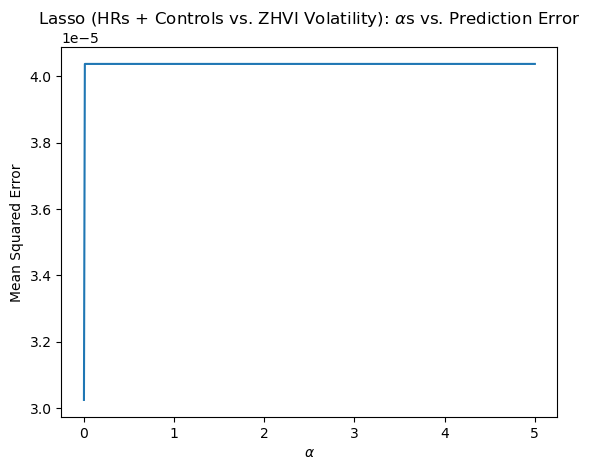

In [25]:
# Conduct LASSO Regression on yearly volatility in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Conduct standardized OLS regression

std_ols_vol_X = make_pipeline(StandardScaler(with_mean=False), 
                             LinearRegression())
std_ols_vol_X.fit(X_train, y_train)

y_pred = std_ols_vol_X.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_vol_X = None
opt_alpha_lasso_vol_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_vol_X = alphas[counter]
        opt_coefs_lasso_vol_X = model['lasso'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_lasso_vol_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs + Controls vs. ZHVI Volatility): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaXVolZHVILASSO.png')
plt.show()

### Ridge

We conduct this analysis for the same reason as LASSO: to assess variable selection and dimension reduction.

MSE: 4174784785.1909113

1e-06


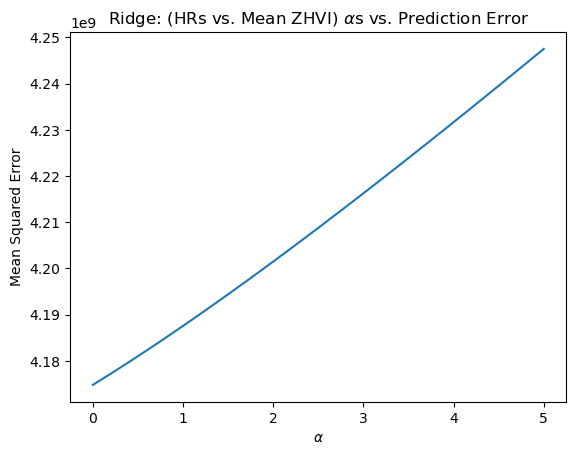

In [26]:
# Conduct Ridge Regression on mean ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_mean_no_X = None
opt_alpha_ridge_mean_no_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_mean_no_X = alphas[counter]
        opt_coefs_ridge_mean_no_X = model['ridge'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print()
print(opt_alpha_ridge_mean_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs vs. Mean ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaMeanZHVIRidge.png')
plt.show()

MSE: 1804088924.8381371
5.0


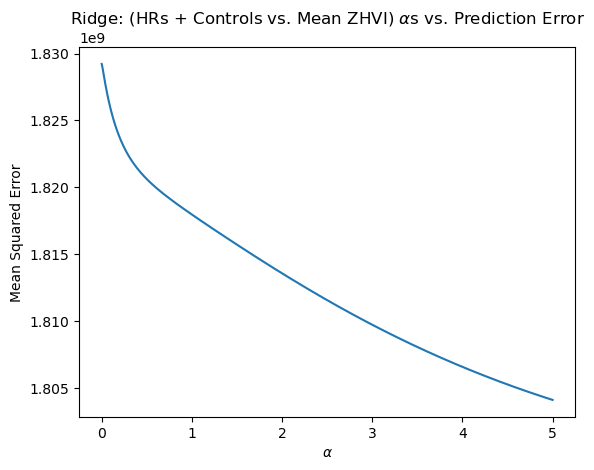

In [27]:
# Conduct Ridge Regression on mean ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_mean_X = None
opt_alpha_ridge_mean_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_mean_X = alphas[counter]
        opt_coefs_ridge_mean_X = model['ridge'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_ridge_mean_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs + Controls vs. Mean ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaXMeanZHVIRidge.png')
plt.show()

MSE: 0.06718102411786023
1.5731469779559117


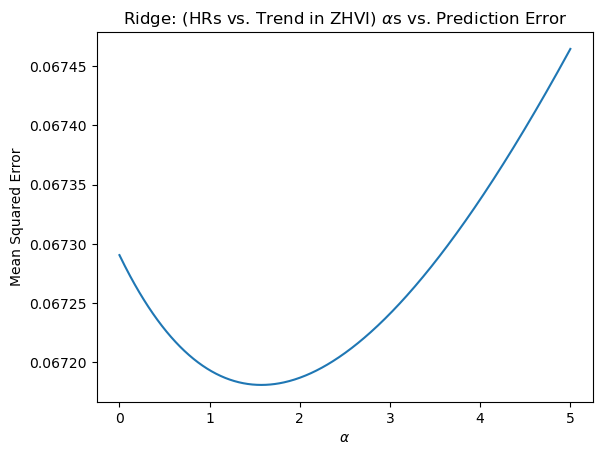

In [28]:
# Conduct Ridge Regression on change in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_trend_no_X = None
opt_alpha_ridge_trend_no_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_trend_no_X = alphas[counter]
        opt_coefs_ridge_trend_no_X = model['ridge'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_ridge_trend_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs vs. Trend in ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaTrendZHVIRidge.png')
plt.show()

MSE: 0.03240594273919566
0.35070233266533063


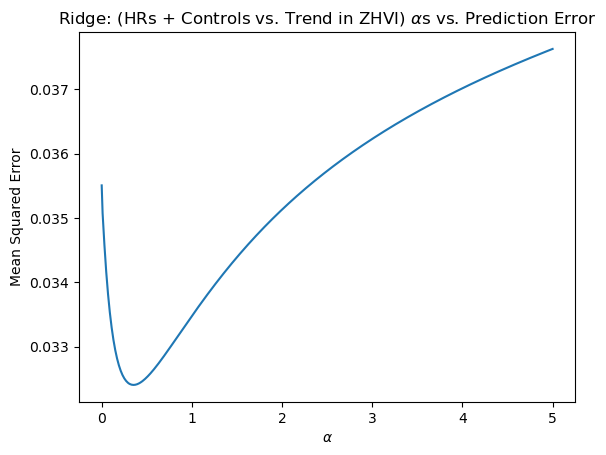

In [29]:
# Conduct Ridge Regression on change in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_trend_X = None
opt_alpha_ridge_trend_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_trend_X = alphas[counter]
        opt_coefs_ridge_trend_X = model['ridge'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_ridge_trend_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs + Controls vs. Trend in ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaXTrendZHVIRidge.png')
plt.show()

MSE: 3.279357642762051e-05
1e-06


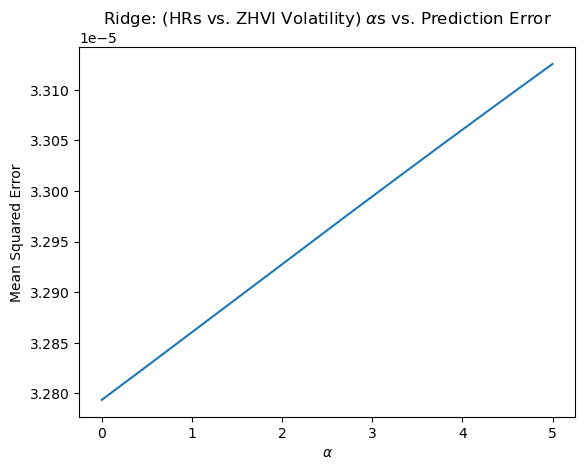

In [30]:
# Conduct Ridge Regression on mean yearly variance in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_vol_no_X = None
opt_alpha_ridge_vol_no_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_vol_no_X = alphas[counter]
        opt_coefs_ridge_vol_no_X = model['ridge'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_ridge_vol_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs vs. ZHVI Volatility) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaVolZHVIRidge.png')
plt.show()

MSE: 3.0237311411806724e-05
1.0921851503006013


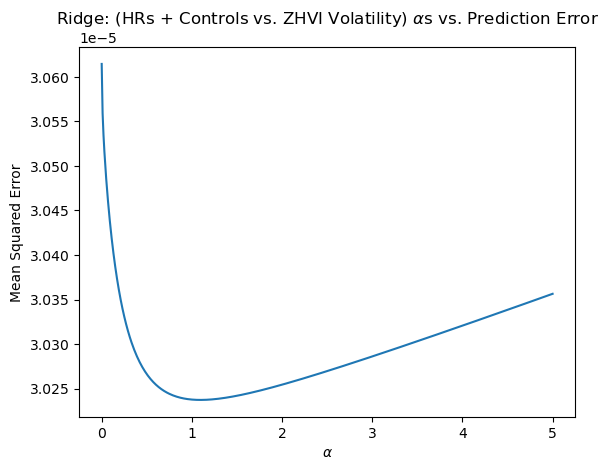

In [31]:
# Conduct Ridge Regression on mean yearly variance in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_vol_X = None
opt_alpha_ridge_vol_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_vol_X = alphas[counter]
        opt_coefs_ridge_vol_X = model['ridge'].coef_
    counter += 1
    
print("MSE:", min_MSE)
print(opt_alpha_ridge_vol_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs + Controls vs. ZHVI Volatility) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaXVolZHVIRidge.png')
plt.show()

### Coefficient Comparison: OLS vs. LASSO vs. Ridge Regressions

Notice here that the inputs to the LASSO and Ridge regressions are scaled, which leads to non-comparable magnitudes for these regressions. We can interpret LASSO and Ridge coefficients in terms of prediction importance.

In [32]:
# Mean ZHVI (no controls) coefficient comparison

### Standardized OLS

coef_comp = pd.DataFrame({
    'var' : hr_vars,
    'val_ols' : mean_ols_no_X.params.tolist()[1:], 
    'val_lasso' : opt_coefs_lasso_mean_no_X, 
    'var_ridge' : opt_coefs_ridge_mean_no_X
})

print("Mean ZHVI vs. Hazard Risk")
print(coef_comp)

Mean ZHVI vs. Hazard Risk
                  var      val_ols     val_lasso     var_ridge
0           Avalanche  1279.268287  18952.225521  18952.225200
1    Coastal Flooding  1183.125992  25494.073344  25494.072809
2           Cold Wave   -20.393154   -391.034140   -391.034153
3             Drought    -3.249366   -596.479294   -596.479396
4          Earthquake    58.063314    814.761005    814.761311
5                Hail  -112.184755  -2824.104035  -2824.104106
6           Heat Wave     2.589900    -44.117339    -44.117482
7           Hurricane  -218.056355  -5913.221348  -5913.221018
8           Ice Storm   -65.313606  -1229.984812  -1229.984904
9           Landslide   178.267782   4993.047203   4993.047204
10          Lightning   509.637096  14532.202794  14532.202096
11  Riverine Flooding    41.011478    363.995323    363.995515
12        Strong Wind    87.494614   2512.743314   2512.743061
13            Tornado  -255.437492  -7683.227718  -7683.227273
14            Tsunami  1880.2

In [33]:
# Mean ZHVI (with controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars + control_vars,
    'val_ols' : std_ols_mean_X["linearregression"].coef_, 
    'val_lasso' : opt_coefs_lasso_mean_X, 
    'var_ridge' : opt_coefs_ridge_mean_X
})

coef_comp.to_csv(path + "\\Figures\\MeanCoefComp.csv")

print("Mean ZHVI vs. Hazard Risk + Controls")
print(coef_comp)

Mean ZHVI vs. Hazard Risk + Controls
                             var       val_ols     val_lasso     var_ridge
0                      Avalanche   8198.685288   8211.818945   8256.509032
1               Coastal Flooding   3638.697248   3645.450768   5210.916745
2                      Cold Wave -10694.409607 -10638.946452  -8822.587913
3                        Drought   1020.294577    996.972664    901.653262
4                     Earthquake  -2481.144776  -2450.610335  -1628.491121
5                           Hail  -5482.648431  -5499.941881  -5755.684649
6                      Heat Wave     -5.403102     -0.000000     67.898445
7                      Hurricane  -3163.430116  -3019.399377  -1852.729112
8                      Ice Storm  -1997.609251  -1932.431990  -1627.622142
9                      Landslide   1208.213565   1186.414009   1821.872964
10                     Lightning   2424.985252   2282.622193    867.534398
11             Riverine Flooding   1798.405876   1705.723503   

In [34]:
# Trend ZHVI (no controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars,
    'val_ols' : trend_ols_no_X.params.tolist()[1:], 
    'val_lasso' : opt_coefs_lasso_trend_no_X, 
    'var_ridge' : opt_coefs_ridge_trend_no_X
})

print("Trend in ZHVI vs. Hazard Risk")
print(coef_comp)

Trend in ZHVI vs. Hazard Risk
                  var   val_ols  val_lasso  var_ridge
0           Avalanche -0.000168  -0.005830  -0.004376
1    Coastal Flooding  0.002828   0.082624   0.077137
2           Cold Wave  0.000686   0.025181   0.022646
3             Drought  0.000493   0.011957   0.010751
4          Earthquake  0.000029  -0.004688  -0.005845
5                Hail -0.000812  -0.021181  -0.023911
6           Heat Wave -0.000487  -0.008076  -0.007771
7           Hurricane  0.000184   0.004477   0.005600
8           Ice Storm  0.000150   0.003854   0.003405
9           Landslide  0.001481   0.044789   0.042869
10          Lightning -0.000449  -0.007999  -0.008692
11  Riverine Flooding  0.001447   0.037928   0.036347
12        Strong Wind  0.000606   0.015287   0.008531
13            Tornado -0.003292  -0.092947  -0.081681
14            Tsunami  0.003389   0.019029   0.019431
15  Volcanic Activity -0.000840  -0.004531  -0.003793
16           Wildfire  0.000391   0.008917   0.00984

In [35]:
# Trend ZHVI (with controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars + control_vars,
    'val_ols' : std_ols_trend_X["linearregression"].coef_, 
    'val_lasso' : opt_coefs_lasso_trend_X, 
    'var_ridge' : opt_coefs_ridge_trend_X
})

coef_comp.to_csv(path + "\\Figures\\TrendCoefComp.csv")

print("Trend in ZHVI vs. Hazard Risk + Controls")
print(coef_comp)

Trend in ZHVI vs. Hazard Risk + Controls
                             var   val_ols  val_lasso  var_ridge
0                      Avalanche -0.006616  -0.006202  -0.004672
1               Coastal Flooding  0.010044   0.009396   0.014522
2                      Cold Wave -0.015054  -0.015027  -0.008747
3                        Drought  0.005006   0.004940   0.006912
4                     Earthquake -0.007672  -0.008189  -0.011919
5                           Hail -0.013731  -0.013609  -0.017483
6                      Heat Wave -0.039395  -0.039252  -0.036940
7                      Hurricane  0.019276   0.019202   0.023753
8                      Ice Storm -0.001683  -0.000671   0.004082
9                      Landslide  0.006665   0.006793   0.007656
10                     Lightning -0.011778  -0.012372  -0.015928
11             Riverine Flooding  0.023119   0.022803   0.020970
12                   Strong Wind  0.007079   0.006902   0.006772
13                       Tornado -0.075191  -0.07

In [36]:
# Volatility ZHVI (no controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars,
    'val_ols' : vol_ols_no_X.params.tolist()[1:], 
    'val_lasso' : opt_coefs_lasso_vol_no_X, 
    'var_ridge' : opt_coefs_ridge_vol_no_X
})

print("ZHVI Volatility vs. Hazard Risk")
print(coef_comp)

ZHVI Volatility vs. Hazard Risk
                  var       val_ols  val_lasso  var_ridge
0           Avalanche -1.196637e-05  -0.000000  -0.000116
1    Coastal Flooding  5.835248e-05   0.001195   0.001286
2           Cold Wave -9.738691e-07  -0.000028  -0.000083
3             Drought  2.108216e-05   0.000527   0.000572
4          Earthquake  2.133863e-05   0.000463   0.000508
5                Hail  3.585331e-06   0.000000   0.000118
6           Heat Wave  1.649963e-06   0.000000   0.000066
7           Hurricane -2.645422e-05  -0.000645  -0.000829
8           Ice Storm -3.730542e-05  -0.001099  -0.001130
9           Landslide  8.957422e-06   0.000161   0.000201
10          Lightning  1.016907e-05   0.000046   0.000261
11  Riverine Flooding -3.760308e-06  -0.000027  -0.000129
12        Strong Wind  6.133799e-08  -0.000028  -0.000027
13            Tornado -2.512064e-05  -0.000504  -0.000668
14            Tsunami -2.222531e-06   0.000008   0.000022
15  Volcanic Activity  1.416791e-05   0.

In [37]:
# Volatility ZHVI (with controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars + control_vars,
    'val_ols' : std_ols_vol_X["linearregression"].coef_, 
    'val_lasso' : opt_coefs_lasso_vol_X, 
    'var_ridge' : opt_coefs_ridge_vol_X
})

coef_comp.to_csv(path + "\\Figures\\VolCoefComp.csv")

print("ZHVI Volatility vs. Hazard Risk + Controls")
print(coef_comp)

ZHVI Volatility vs. Hazard Risk + Controls
                             var   val_ols  val_lasso  var_ridge
0                      Avalanche -0.000122  -0.000023  -0.000122
1               Coastal Flooding  0.000855   0.000806   0.000836
2                      Cold Wave -0.000014  -0.000000  -0.000015
3                        Drought  0.000518   0.000409   0.000475
4                     Earthquake  0.000162   0.000194   0.000213
5                           Hail -0.000191  -0.000124  -0.000169
6                      Heat Wave -0.000183  -0.000055  -0.000158
7                      Hurricane -0.001193  -0.000963  -0.001114
8                      Ice Storm -0.000671  -0.000728  -0.000699
9                      Landslide  0.000012   0.000010   0.000046
10                     Lightning  0.000250   0.000100   0.000223
11             Riverine Flooding -0.000409  -0.000269  -0.000350
12                   Strong Wind  0.000017  -0.000009  -0.000051
13                       Tornado -0.001002  -0.